In [38]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
# for better resolution plots
%config InlineBackend.figure_format = 'retina'

# path to folder
base_path = r"C:/Users/Utilizador/Desktop/data science/ml/project_data"
train_path = os.path.join(base_path, "train.csv")
df_train = pd.read_csv(train_path, delimiter=',', header=0, decimal='.', quotechar='"')

X_train = df_train.drop('price', axis = 1)
y = df_train['price']

X_val = pd.read_csv(os.path.join(base_path, "test.csv"), delimiter=',', header=0, decimal='.', quotechar='"')

**Basic** **analysis**

No duplicate values on the dataset, neither in the training or test


In [41]:
X_train.shape

(75973, 13)

In [ ]:
print(X_train.describe())
print("\nNaN values in each column:\n",X_train.isna().sum())
print("\nDuplicated values:", X_train.duplicated().sum())


print("\nNaN values in each column:\n",X_val.isna().sum())
print("\nDuplicated values:", X_val.duplicated().sum())


NaN values in each column:
 carID                0
Brand              649
model              650
year               653
transmission       623
mileage            689
fuelType           656
tax               3308
mpg               3288
engineSize         628
paintQuality%      625
previousOwners     597
hasDamage          597
dtype: int64

Duplicated values: 0


['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']


Text(0.5, 0.98, "Numeric Variables' Histograms")

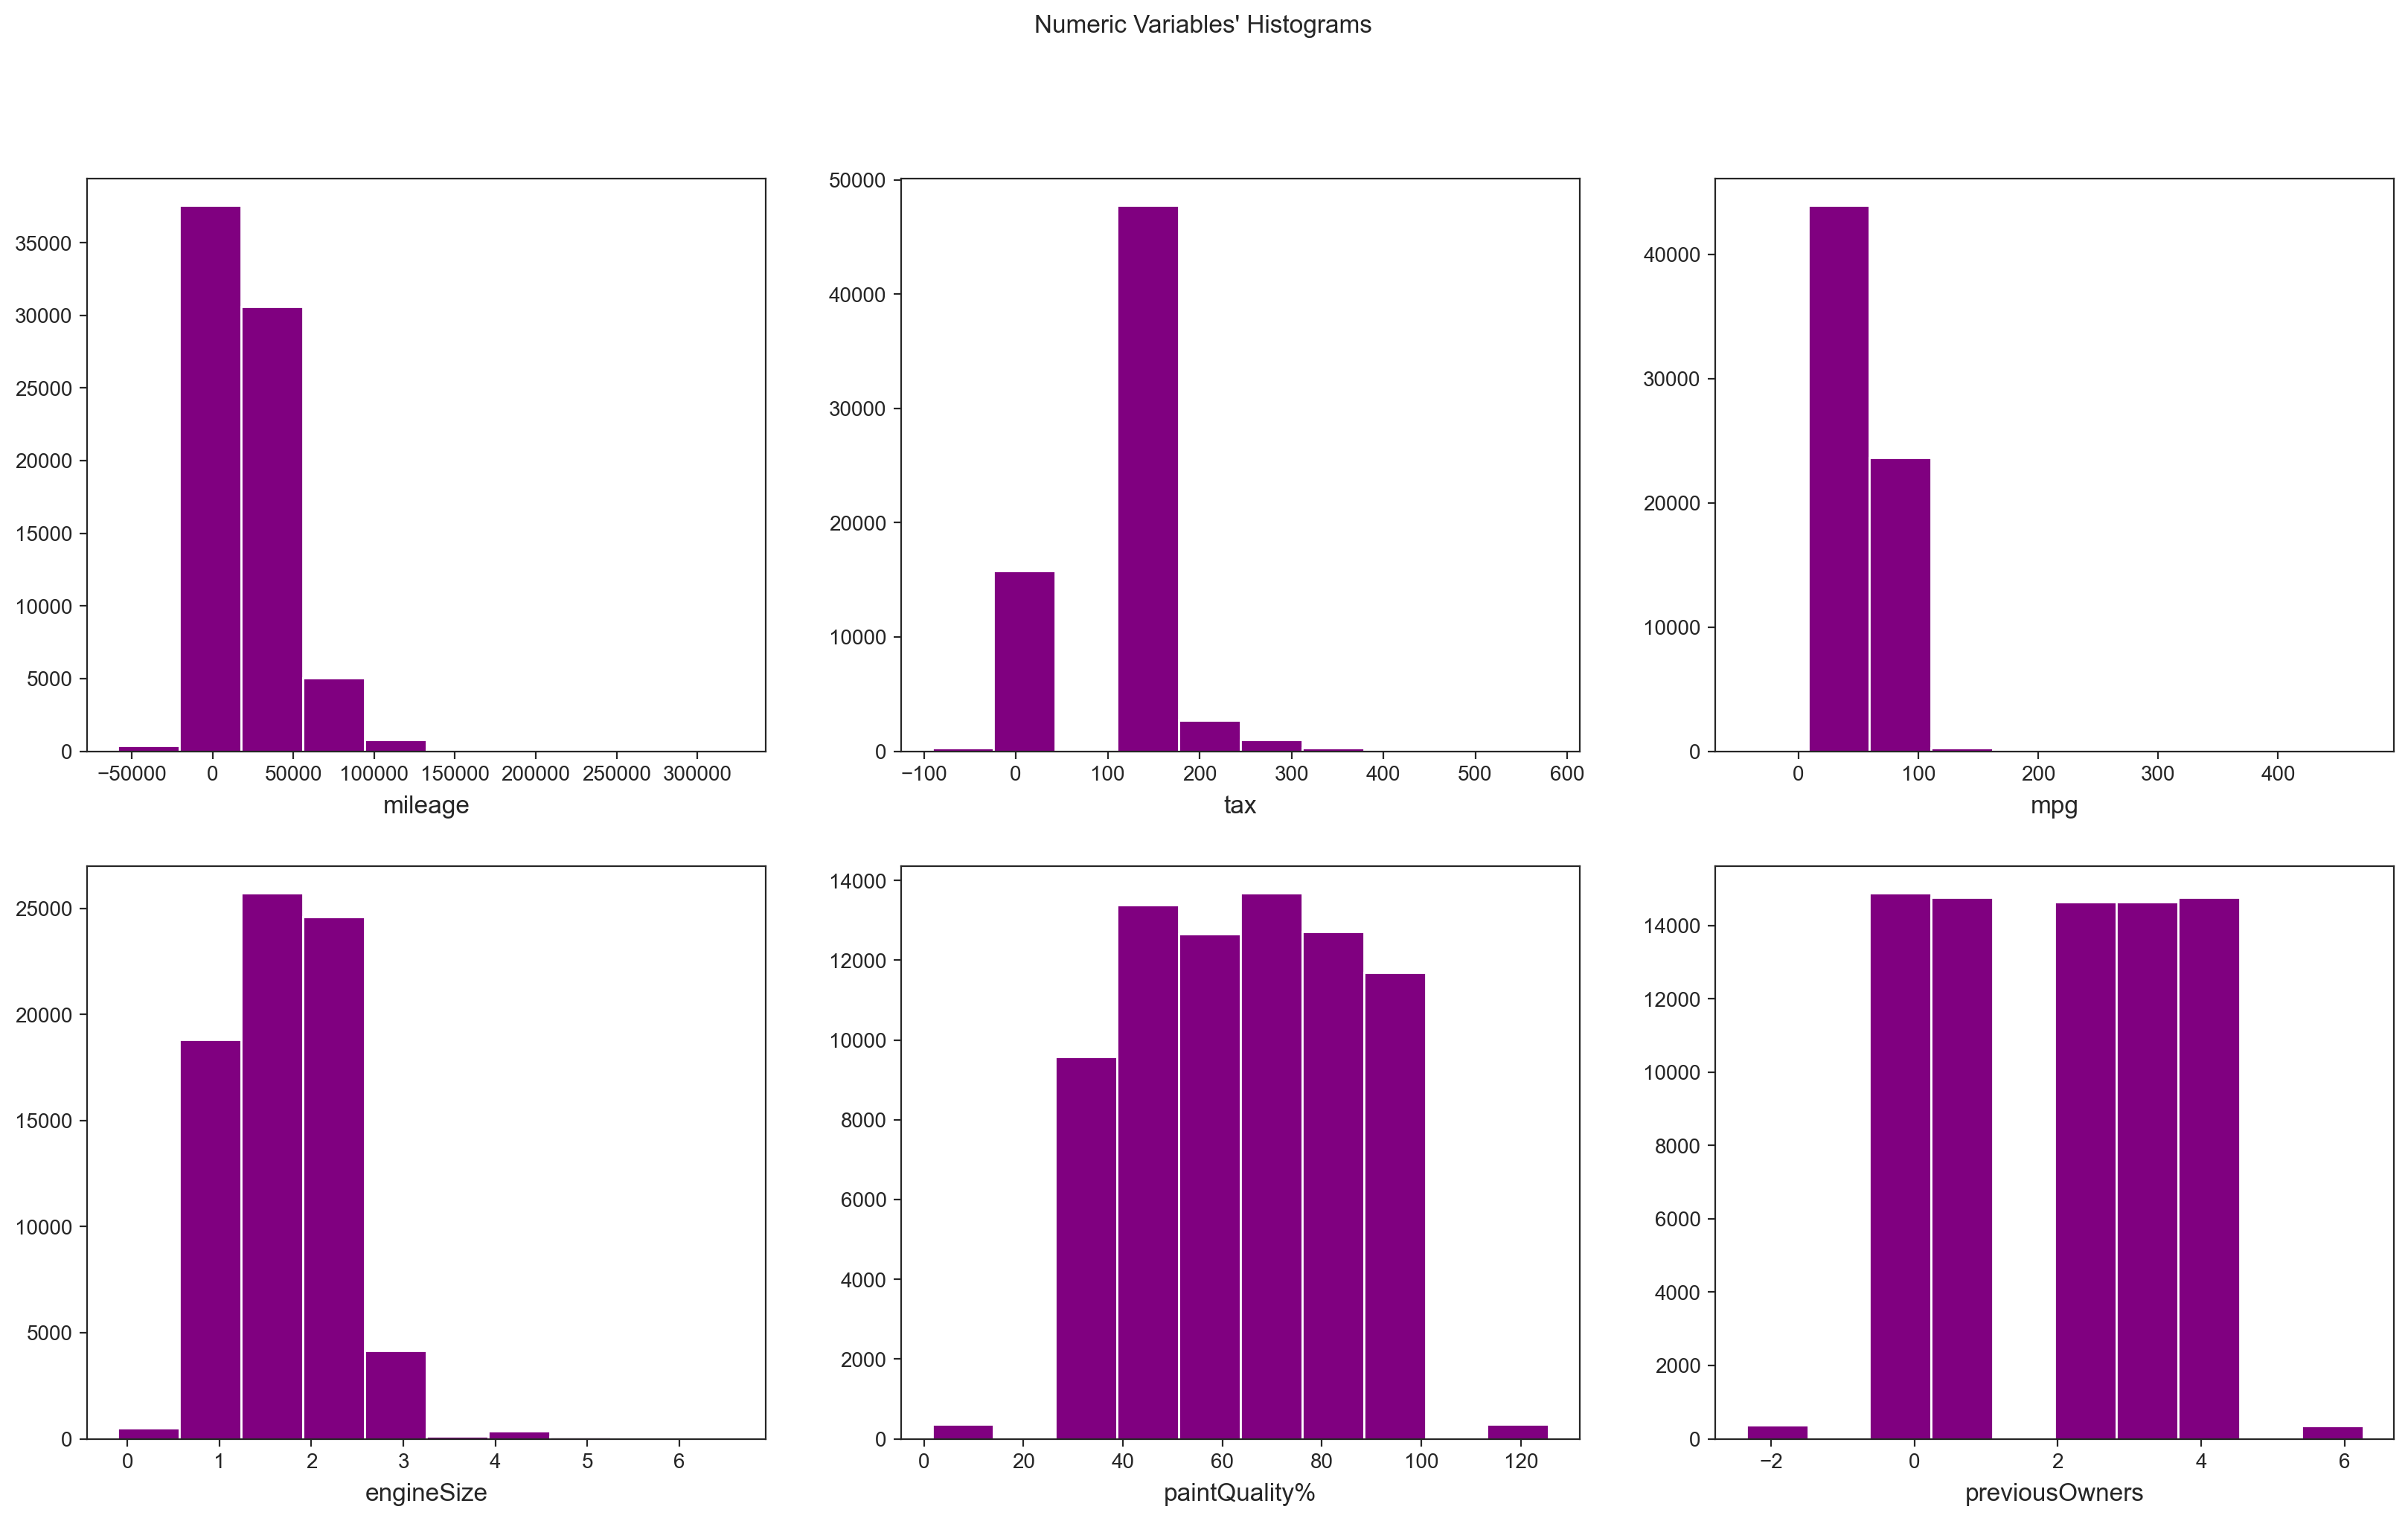

In [4]:
cat_features=["carID", "Brand", "model", "year", "fuelType", "hasDamage", "transmission"]
metric_features=X_train.columns.drop(cat_features).tolist()
print(metric_features)


sp_rows = 2
sp_cols = 3


#Histograms
sns.set_style("ticks")
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): 
    ax.hist(df_train[feat], color=("purple"))
    ax.set_title(feat, y=-0.13)  
# Layout
plt.suptitle("Numeric Variables' Histograms")

###### ponderar se faz sentido log da 1 e 3 var

Text(0.5, 0.98, 'BoxPlots')

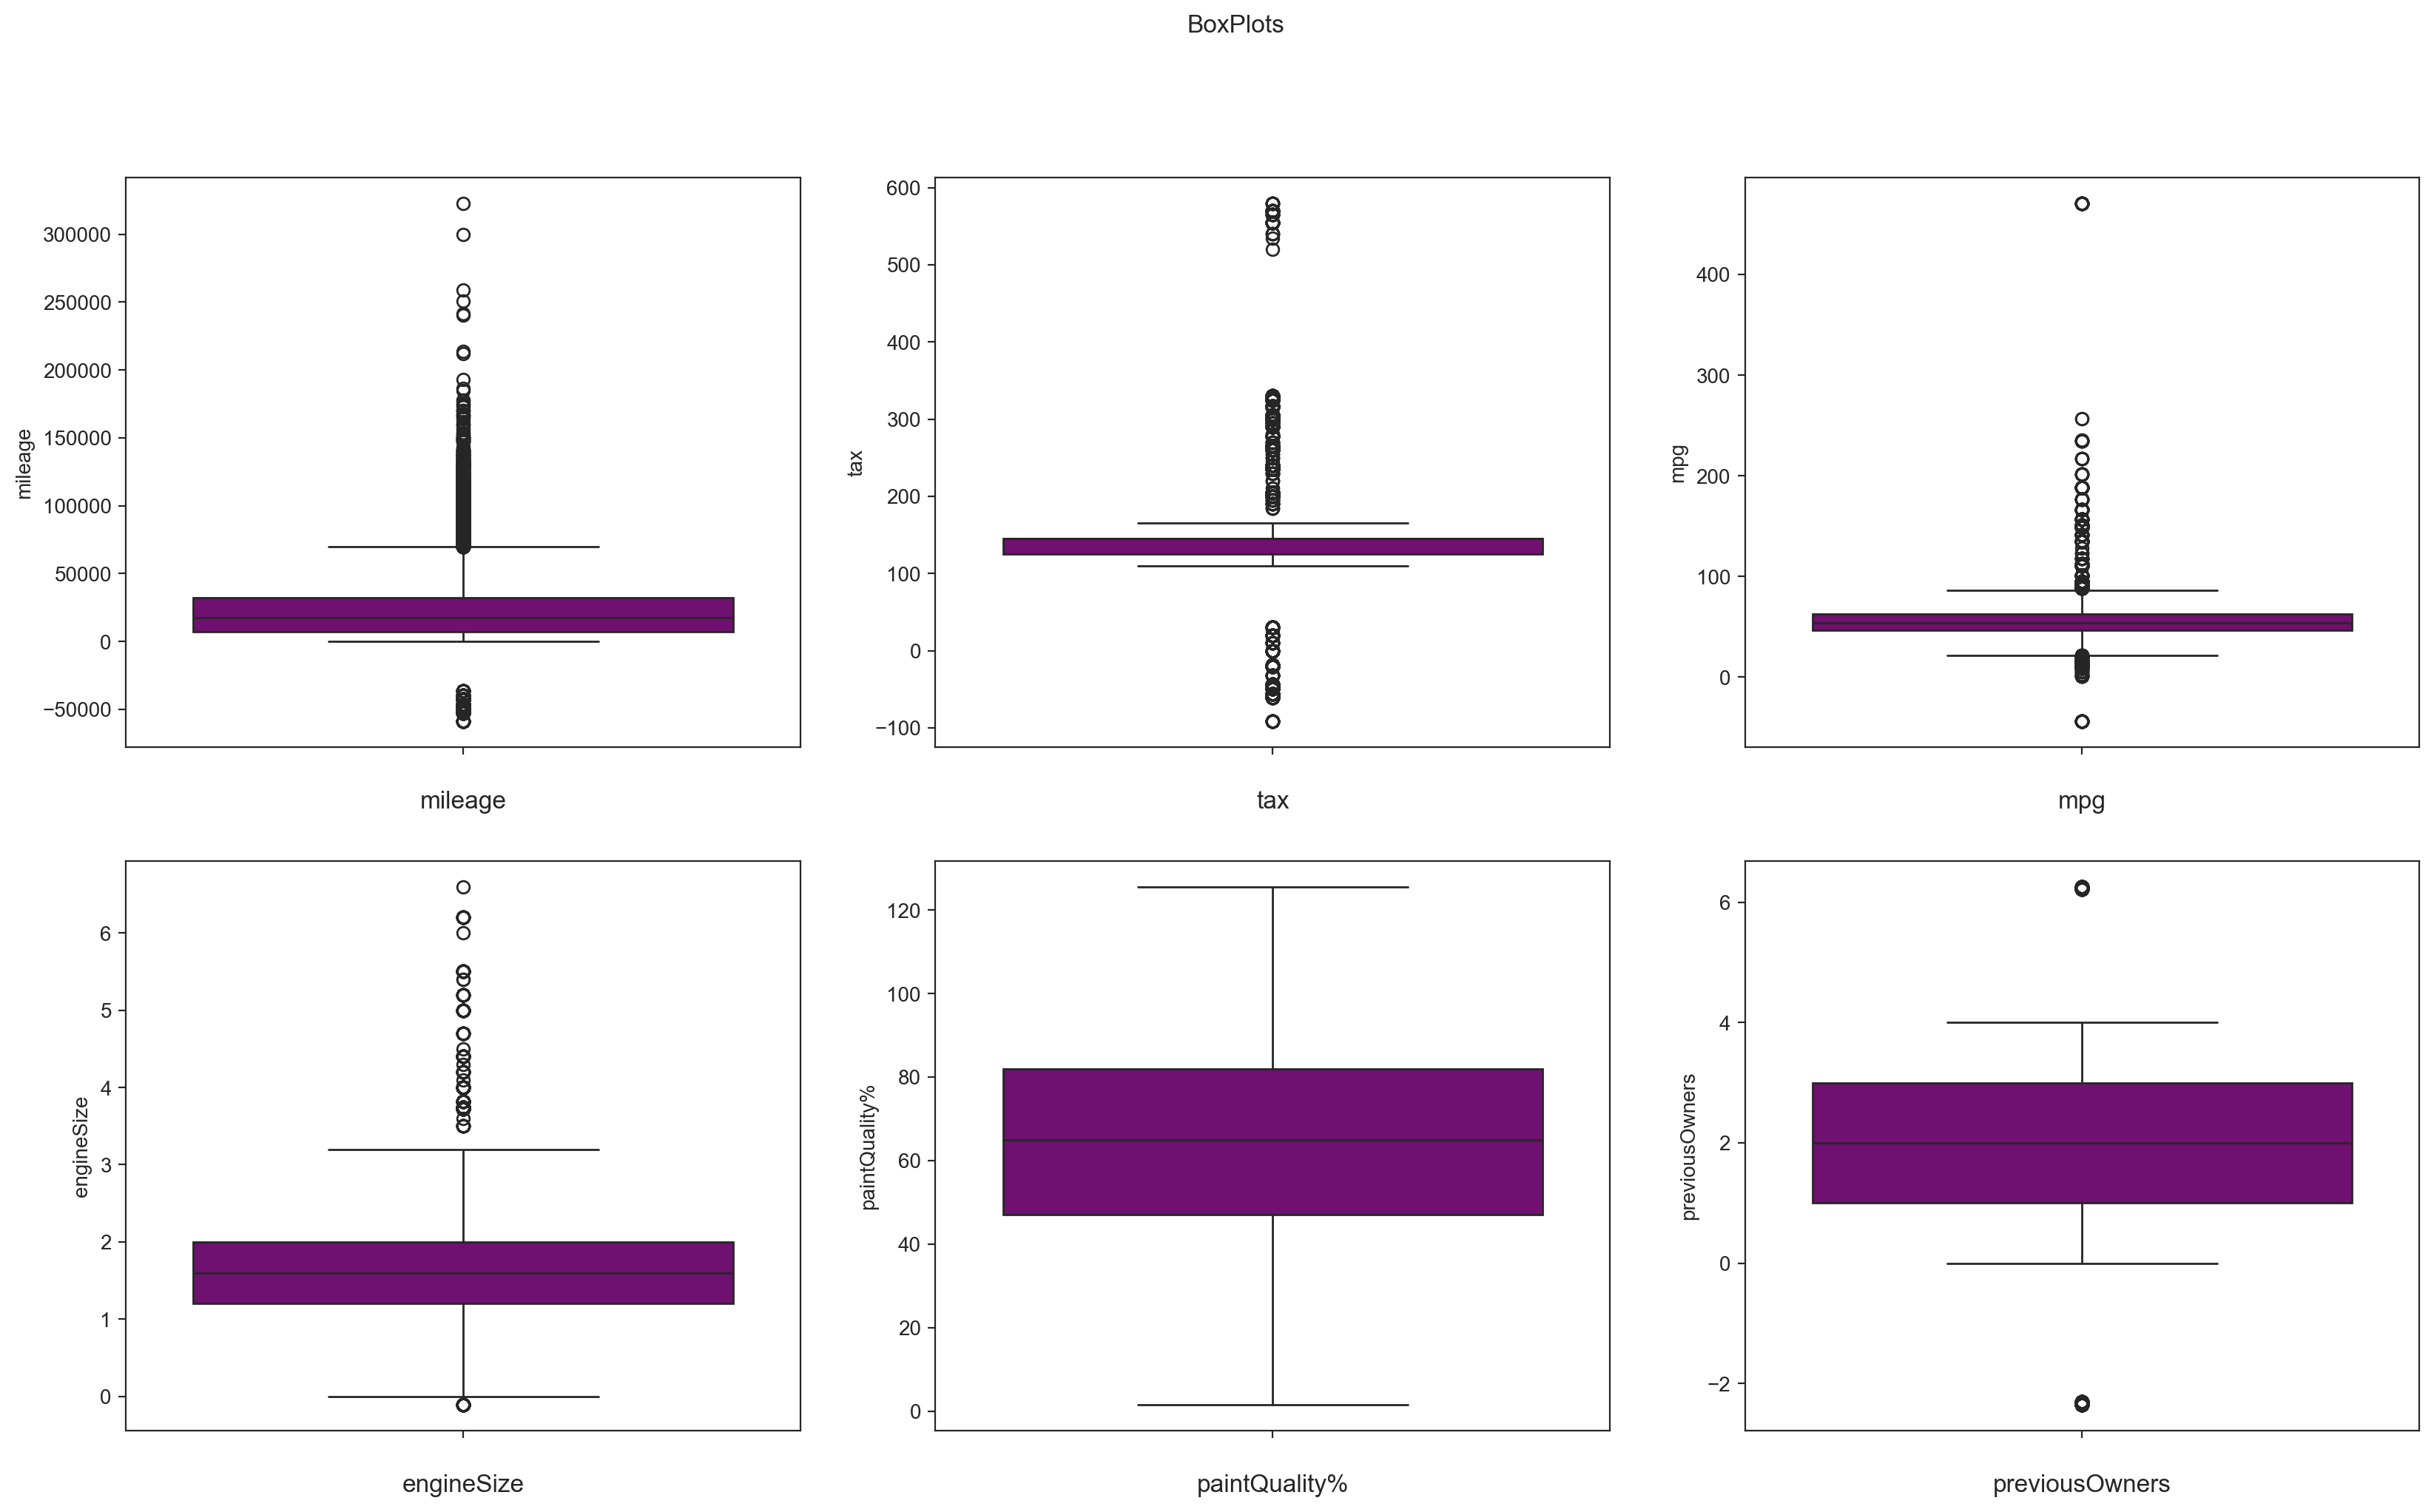

In [5]:
#boxplot
# Prepare figure. Create individual axes where each boxplot will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(y=df_train[feat],ax=ax, color=("purple"))
    ax.set_title(feat, y=-0.13) 

plt.suptitle("BoxPlots")

###### em tax e mpg cortar outliers manualmente pelos 400
###### mileage ? engineSize?

### Outliers

We will manually remove the group of observations that are far apart from the data
Does not make sense to have a negative tax as well

Percentage of data kept after removing outliers: 0.8944


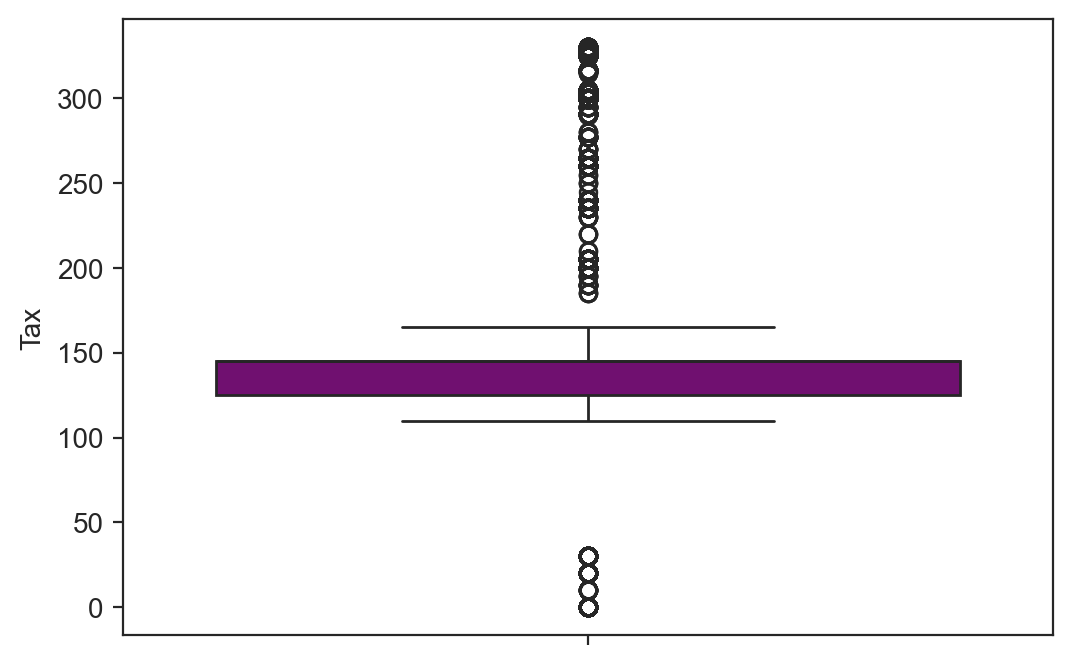

In [6]:

X_train["tax"].unique()
mask=(X_train["tax"]<0)
X_train.loc[mask, "tax"] = 0
X_train["tax"].unique()

filters_mpg = ((X_train['tax']<400))


X_manuallyremoved = X_train[filters_mpg]
print('Percentage of data kept after removing outliers:', np.round(X_manuallyremoved.shape[0] / X_train.shape[0], 4))

plt.figure(figsize=(6,4))
sns.boxplot(y=X_manuallyremoved["tax"], color="purple")
plt.ylabel("Tax")
plt.show()

Does not make sense to have negative previousOwners and we can already remove the far out outliers manually

###### on the last 2 feautures we substituted the negative values with 0 (?) or do we just remove it

Percentage of data kept after removing outliers: 0.8671


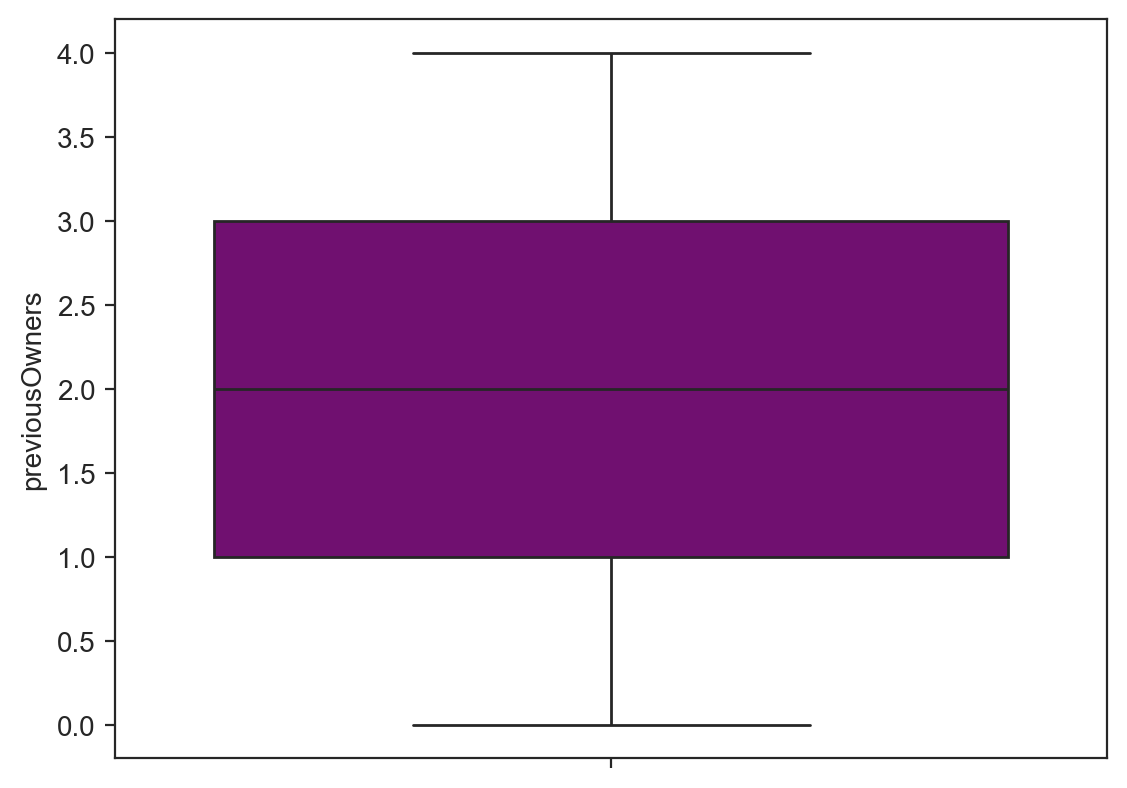

array([1., 4., 3., 0., 2.])

In [7]:
filters_PO = ((X_train['previousOwners']<= 4) & (X_train['previousOwners']>= 0 ))


X_manuallyremoved = X_train[filters_PO & filters_mpg]
print('Percentage of data kept after removing outliers:', np.round(X_manuallyremoved.shape[0] / X_train.shape[0], 4))

sns.boxplot(y=X_manuallyremoved["previousOwners"], color="purple")
plt.show()

X_manuallyremoved["previousOwners"].unique()


 Lets also remove manually the outliers from mpg that distort the data too far up 
 
also removing negative values that dont make sense to exist in this feature (probably errors)

Percentage of data kept after removing outliers: 0.8677


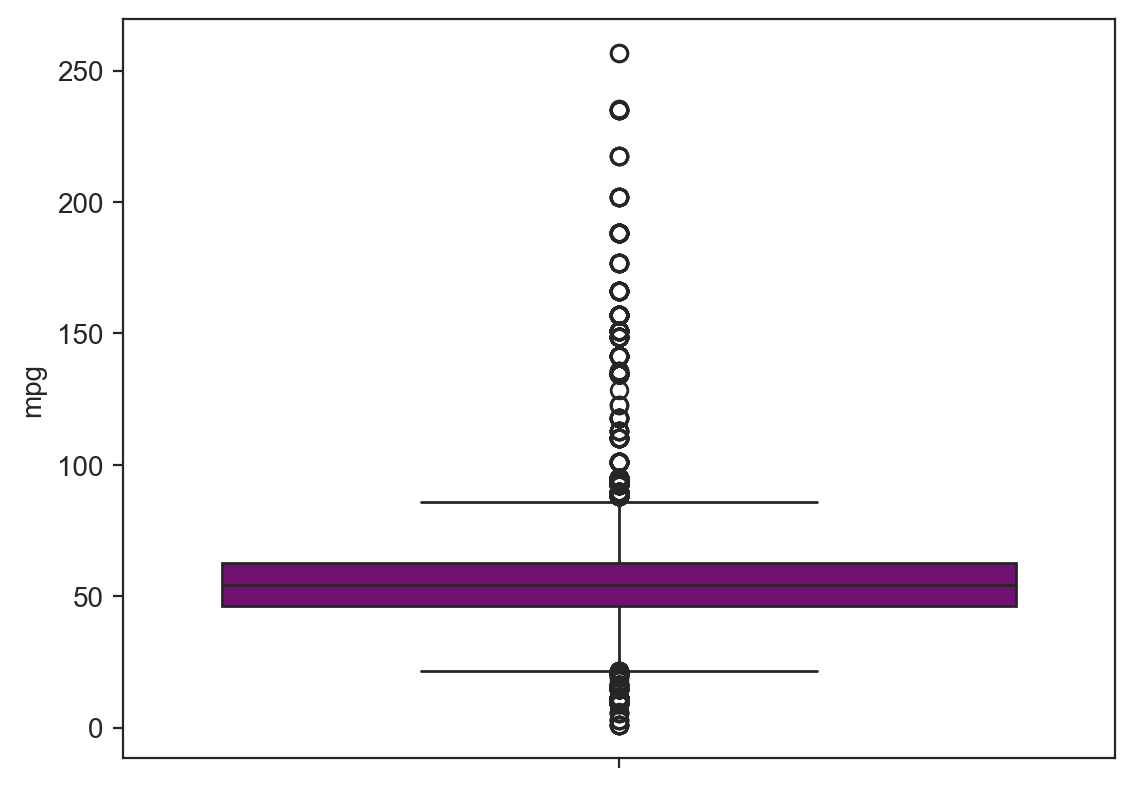

In [8]:
filters_mpg = (X_train['mpg']<= 400) & (X_train['mpg']>= 0)


X_manuallyremoved = X_train[filters_mpg & filters_PO & filters_mpg]
print('Percentage of data kept after removing outliers:', np.round(X_manuallyremoved.shape[0] / X_train.shape[0], 4))

sns.boxplot(y=X_manuallyremoved["mpg"], color="purple")
plt.show()


Lets clean the data on mileage and engineSize to handle outliers later on

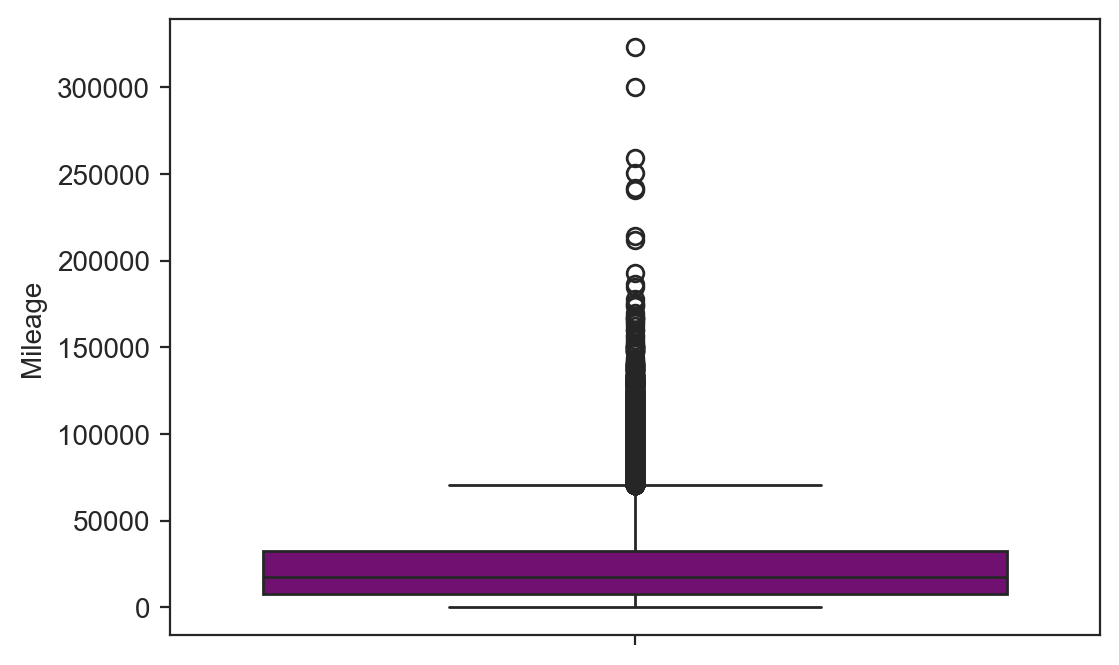

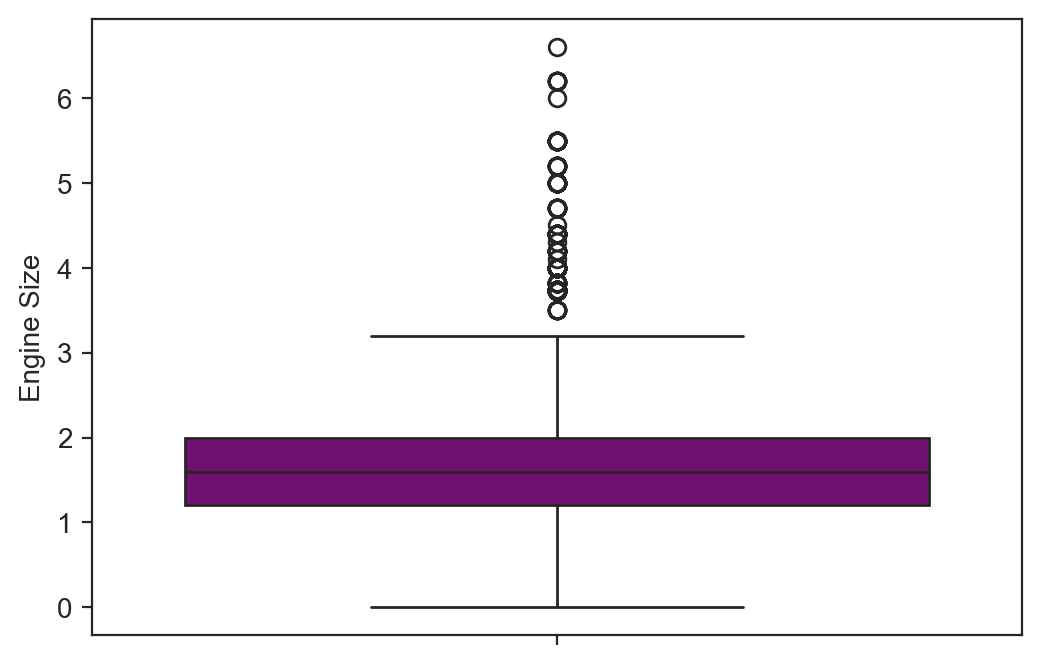

Percentage of data kept after removing outliers: 0.8288


In [9]:
X_manuallyremoved = X_manuallyremoved[X_manuallyremoved["mileage"] >= 0]



plt.figure(figsize=(6,4))
sns.boxplot(y=X_manuallyremoved["mileage"], color="purple")
plt.ylabel("Mileage")
plt.show()


X_manuallyremoved = X_manuallyremoved[X_manuallyremoved["engineSize"] >= 0]


plt.figure(figsize=(6,4))
sns.boxplot(y=X_manuallyremoved["engineSize"], color="purple")
plt.ylabel("Engine Size")
plt.show()

print('Percentage of data kept after removing outliers:', np.round(X_manuallyremoved.shape[0] / X_train.shape[0], 4))


### Categorical Features

fuelType
Petrol      41181
Diesel      30885
Hybrid       2225
NaN          1511
Other         167
Electric        4
Name: count, dtype: int64

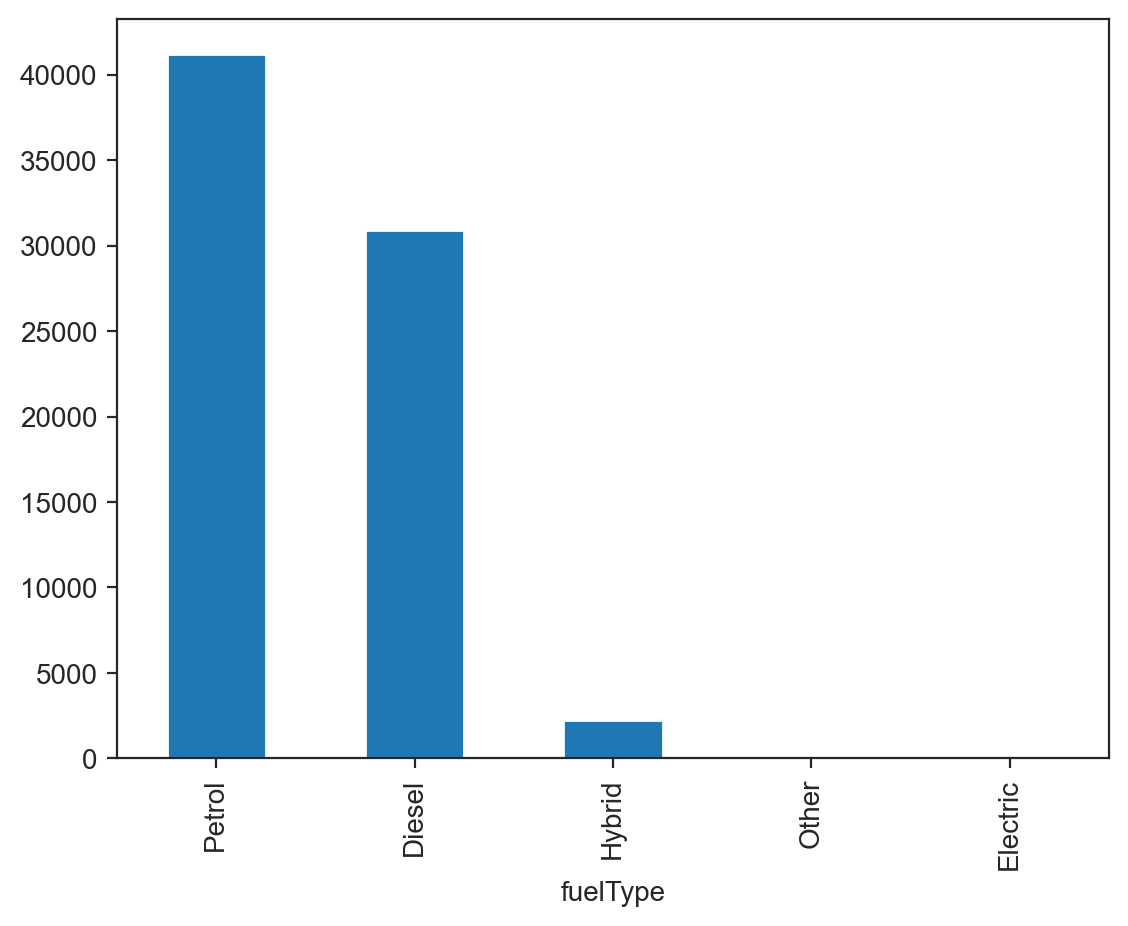

In [10]:
#Typos in the fuel type need to be fixed
#easy way of doing 
"""
import re
X_train["fuelType"] = (
    X_train["fuelType"]
    .str.strip()                      # remove espaços no início/fim
    .str.replace(r"(?i).*diesel.*", "Diesel", regex=True)
    .str.replace(r"(?i).*petrol.*", "Petrol", regex=True)
    .str.replace(r"(?i).*hybrid.*", "Hybrid", regex=True)
    .str.replace(r"(?i).*other.*", "Other", regex=True)
)
"""
diesel_types=["DIESEL","Diese","diesel","iesel","IESEL","DIESE","iese","diese","IESE"]
petrol_types=["petrol","Petro","etrol", "PETROL","petro","etro","ETROL","PETRO","ETRO"]
hybrid_types=["HYBRID", "hybrid","Hybri","ybrid","HYBRI","ybri","YBRID"]
other=["ther","Othe","OTHER","other"]
X_train["fuelType"]=X_train["fuelType"].apply(lambda i: "Diesel" if i in diesel_types else i)
X_train["fuelType"]=X_train["fuelType"].apply(lambda i: "Petrol" if i in petrol_types else i)
X_train["fuelType"]=X_train["fuelType"].apply(lambda i: "Hybrid" if i in hybrid_types else i)
X_train["fuelType"]=X_train["fuelType"].apply(lambda i: "Other" if i in other else i)
X_train["fuelType"].value_counts().plot(kind="bar")

X_train.loc[X_train["fuelType"].isin(["nan"]), "fuelType"] = np.nan
X_train["fuelType"].value_counts(dropna=False)

 o que fazer com Others? Substituir NaN com moda ou ?

np.int64(1521)

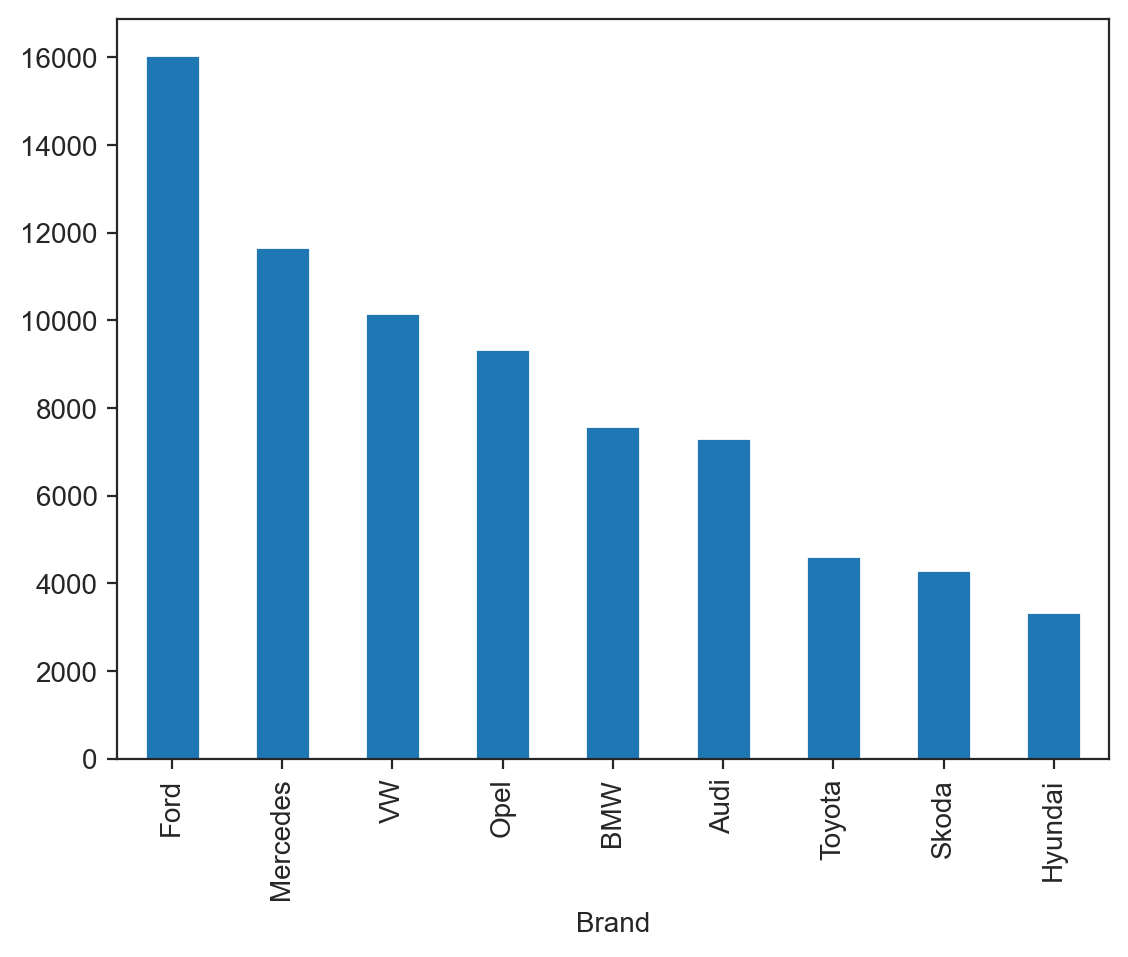

In [11]:
#Typos in the brand need to be fixed
X_train["Brand"].unique()

bmw_types=["w","MW","bmw","BM","W","mw"]
toyota_types=["Toyot","TOYOTA","toyota","OYOTA","TOYOT","toyot","oyota"]

X_train["Brand"]=X_train["Brand"].apply(lambda i: "BMW" if i in bmw_types else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Toyota" if i in toyota_types else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Skoda" if i in ["KOD","koda","SKOD","KODA","skod","SKODA","Skod","skoda","kod"] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Audi" if i in ["UD","AUDI","audi","Aud","UDI","AUD","udi","aud","ud"] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Ford" if i in ["OR","ord","ford","for","ORD"] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Mercedes" if i in ["Mercede","MERCEDES","ercedes","MERCEDE","ercede","ERCEDES","mercede","mercedes"] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Opel" if i in ["Ope","OPE","ope","opel","pel","pe","OPEL","PEL"] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Ford" if i in ["FOR","For","or","FORD"] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "Hyundai" if i in ['yundai', 'Hyunda', 'hyundai','HYUNDAI', 'yunda', 'HYUNDA', 'hyunda'] else i)
X_train["Brand"]=X_train["Brand"].apply(lambda i: "VW" if i in ['v','V','vw'] else i)

X_train["Brand"].unique()
X_train.loc[X_train["Brand"].isin(["nan","Other"]), "Brand"] = np.nan
X_train["Brand"].value_counts().plot(kind="bar")

X_train["Brand"].isna().sum()






In [12]:
#typos in model type

# --------- FIXING CAR MODELS -------------------

car_models = {
    "GOLF": ['Golf', 'Gol', ' GOLF', ' golf', ' golf s', ' Gol', ' Golf SV', ' golf sv', 'Golf', 'golf', ' GOLF', ' Golf S', ' gol', ' GOL', ' Golf'],
    "POLO": ['Polo', 'Pol', 'polo', ' POLO', ' polo', ' Pol', ' Polo', 'POLO'],
    "PASSAT": ['Passat', ' PASSAT', ' Passa', ' passa', ' Passa', ' Passa', ' passat', ' Passat'],
    "TIGUAN": ['Tiguan', ' Tiguan', ' TIGUAN', 'Tigua', ' tiguan', ' Tigua', ' TIGUA', ' tiguan', ' Tiguan', 'TIGUAN', 'tiguan'],
    "TIGUAN_ALLSPACE": [' tiguan allspace', ' Tiguan Allspac', 'Tiguan Allspace', ' TIGUAN ALLSPACE', ' Tiguan Allspace'],
    "TOUAREG": ['Touareg', ' TOUAREG', ' touareg', ' Touare', ' Touareg'],
    "T_ROC": ['T-Roc', ' T-Ro', ' t roc', ' T-Roc'],
    "T_CROSS": ['T-Cross', ' T-CROSS', ' t-cros', ' t cross', ' T-Cros', ' T-RO', ' T-ROC', ' t-roc', ' t-cross', 'T-Cross', ' T-Cross'],
    "ARTEON": ['Arteon', ' arteon', ' Arteo', ' ARTEON', ' Arteon'],
    "SHARAN": ['Sharan', ' sharan', ' SHARAN', ' Shara', ' Sharan', ' Sharan'],
    "JETTA": ['Jetta', ' Jetta', ' JETTA'],
    "CC": ['CC', ' cc', ' CC'],
    "CARAVELLE": ['Caravelle', ' caravelle', ' Caravell', ' Caravelle'],
    "CALIFORNIA": ['California', ' California'],
    "CADDY": ['Caddy', ' Caddy'],
    "CADDY_MAXI": ['Caddy Maxi Life', ' Caddy Maxi Lif', ' Caddy Maxi', ' Caddy Maxi Life', ' Caddy Life'],
    "TOURAN": ['Touran', ' touran', ' TOURAN', ' Touran', 'Toura', ' TOURA', ' Toura'],
    "GOLF_SV": ['Golf SV', 'Golf S', ' golf sv', ' GOLF SV', 'Golf SV'],
    "BEETLE": ['Beetle', ' beetle', ' Beetl', ' Beetle'],
    "SCIROCCO": ['Scirocco', ' scirocco', ' Scirocc', ' SCIROCCO', ' Scirocco'],
    "UP": ['Up', ' up', ' UP', ' Up', ' U', 'U', 'UP'],
    "AMAROK": ['Amarok', ' Amarok', ' amarok', ' Amaro'],
    "EOS": ['Eos', ' Eos'],
    "FOX": ['Fox', ' Fox'], "FOCUS": ['Focus', 'FOCUS', ' focus', ' FOCUS', ' FOCU', ' Focu', ' focu', ' Focus', 'Focu', 'focus'],
    "FIESTA": ['Fiesta', ' FIESTA', ' Fiest', 'fiesta', ' fiesta', ' Fiest', ' FIEST', ' fiest', ' Fiesta', 'Fiest'],
    "MONDEO": ['Mondeo', ' MONDEO', ' mondeo', ' Monde', ' MONDE', ' Mondeo'],
    "KUGA": ['Kuga', ' KUGA', ' kuga', ' Kug', ' kuga', ' Kuga', 'kuga'],
    "GALAXY": ['Galaxy', ' GALAXY', ' Galax', ' galax', ' Galaxy', ' galaxy'],
    "S_MAX": ['S-MAX', ' s-max', ' S-MA', ' s-ma', ' S-MAX'],
    "B_MAX": ['B-MAX', ' B-MA', ' b-max', ' B-MA', ' B-MAX', 'B-MA'],
    "ECOSPORT": ['EcoSport', ' ecosport', ' ECOSPORT', ' EcoSpor', ' EcoSport'],
    "PUMA": ['Puma', ' puma', ' PUMA', ' Puma'],
    "TOURNEO_CUSTOM": ['Tourneo Custom', ' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    "TOURNEO_CONNECT": ['Tourneo Connect', ' Grand Tourneo Connect', ' tourneo connect', ' Tourneo Connect'],
    "KA": ['Ka', ' KA', ' ka', ' Ka'],
    "KA_PLUS": [' Ka+', ' ka+', ' KA+', 'Ka+', 'ka+'],
    "C_MAX": ['C-MAX', ' C-MAX', ' c-max', ' C-MA'],
    "GRAND_C_MAX": [' Grand C-MAX', ' GRAND C-MAX', ' Grand C-MA', ' grand c-max'],
    "EDGE": ['Edge', ' edge', ' EDGE', ' Edge', ' Edg'],
    "MUSTANG": ['Mustang', ' mustang', ' Mustang'],
    "GRAND_TOURNEO_CONNECT": [' Grand Tourneo Connec'],
    "FUSION": ['Fusion', ' Fusion'],
    "STREETKA": ['Streeka', ' Streetka'],
    "RANGER": ['Ranger', ' Ranger'],
    "ESCORT": ['Escort', ' Escort'], "CORSA": ['Corsa', 'corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', ' Corsa'],
    "ASTRA": ['Astra', 'ASTRA', 'astra', ' astra', ' ASTRA', ' ASTRA', ' Astr', 'Astra', ' Astra'],
    "INSIGNIA": ['Insignia', 'Insigni', ' INSIGNIA', ' insignia', ' Insigni', ' INSIGNI', ' Insignia'],
    "MOKKA": ['Mokka', 'Mokk', ' MOKKA', ' Mokka X', ' mokka', ' mokka x', ' MOKKA X', ' Mokk', ' Mokk', ' Mokka ', ' mokka ', ' Mokka X', ' Mokka', 'Mokka X'],
    "ZAFIRA": ['Zafira', ' zafira', ' ZAFIRA', ' Zafir', ' Zafira Tourer', ' Zafira Toure', ' ZAFIRA TOURER', 'Zafira Tourer', ' Zafira', 'Zafir'],
    "VIVA": ['Viva', ' viva', ' VIVA', ' Viva', ' Viv', ' Viva'],
    "MERIVA": ['Meriva', ' meriva', ' MERIVA', ' Meriv', ' Meriva'],
    "ADAM": ['Adam', ' adam', ' Ada', ' ADAM', ' Adam'],
    "COMBO_LIFE": ['Combo Life', 'COMBO LIFE', ' combo life', ' COMBO LIFE', ' Combo Lif', ' Combo Life'],
    "CROSSLAND_X": ['Crossland X', ' CROSSLAND X', ' crossland x', ' Crossland ', ' CrosslandX', ' Crossland X'],
    "GRANDLAND_X": ['Grandland X', ' Grandland X', ' grandland x', ' GRANDLAND X', ' Grandland ', ' grandland ', ' Grandland X'],
    "GTC": ['GTC', ' gtc', ' GTC', 'gtc'],
    "ANTARA": ['Antara', ' Antara'],
    "VIVARO": ['Vivaro', ' Vivaro'],
    "VECTRA": ['Vectra', ' Vectra', ' VECTRA'],
    "AGILA": ['Agila', ' Agila'],
    "TIGRA": ['Tigra', ' Tigra'],
    "CASCADA": ['Cascada', ' Cascada'],
    "AMPERA": ['Ampera', ' Ampera'], "SERIES_1": ['1 Series', '1 series', '1 SERIES', ' 1 Series', ' 1 SERIES', ' 1 serie', ' 1 Serie', ' 1 SERIE', ' 1 series'],
    "SERIES_2": ['2 Series', '2 Serie', ' 2 Series', ' 2 SERIES', ' 2 Serie', ' 2 serie', ' 2 series'],
    "SERIES_3": ['3 Series', '3 Serie', ' 3 Series', ' 3 SERIES', ' 3 Serie', ' 3 serie', ' 3 series'],
    "SERIES_4": ['4 Series', ' 4 serie', '4 series', ' 4 Series', ' 4 SERIES', ' 4 Serie', ' 4 series'],
    "SERIES_5": ['5 Series', '5 SERIES', ' 5 Series', ' 5 SERIES', ' 5 Serie', ' 5 series'],
    "SERIES_6": ['6 Series', ' 6 Series', ' 6 SERIES', ' 6 Serie', ' 6 series'],
    "SERIES_7": ['7 Series', ' 7 Series', ' 7 SERIES', ' 7 Serie', ' 7 series'],
    "SERIES_8": ['8 Series', ' 8 SERIES', '8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    "X1": ['X1', ' x1', ' X1', 'x1'],
    "X2": ['X2', ' IX2', ' x2', ' X2'],
    "X3": ['X3', ' x3', ' X3'],
    "X4": ['X4', ' x4', ' X4'],
    "X5": ['X5', ' x5', ' X5'],
    "X6": ['X6', ' x6', ' X6'],
    "X7": ['X7', ' x7', ' X7'],
    "Z3": ['Z3', ' Z3'],
    "Z4": ['Z4', ' z4', ' Z4'],
    "M2": ['M2', ' M2'],
    "M3": ['M3', ' m3', ' M3'],
    "M4": ['M4', ' m4', ' M4'],
    "M5": ['M5', ' M5'],
    "M6": ['M6', ' M6'], "A1": ['A1', ' a1', ' A1'],
    "A2": ['A2', ' A2'],
    "A3": ['A3', ' a3', ' A 3', ' A3', ' a3'],
    "A4": ['A4', ' a4', ' A4', ' a4'],
    "A5": ['A5', ' a5', ' A5'],
    "A6": ['A6', ' A6', ' a6'],
    "A7": ['A7', ' a7', ' A7'],
    "A8": ['A8', ' A8', 'a8'],
    "Q2": ['Q2', ' q2', ' Q2'],
    "Q3": ['Q3', ' q3', ' Q3'],
    "Q5": ['Q5', ' q5', ' Q5', ' q5', 'q5'],
    "Q7": ['Q7', ' q7', ' Q7'],
    "Q8": ['Q8', ' q8', ' Q8'],
    "S3": ['S3', ' s3', ' S3'],
    "S4": ['S4', ' S4'],
    "S5": ['S5', ' S5'],
    "S8": ['S8', ' S8'],
    "RS3": ['RS3', ' RS3'],
    "RS4": ['RS4', ' RS4'],
    "RS5": ['RS5', ' RS5'],
    "RS6": ['RS6', ' RS6'],
    "SQ5": ['SQ5', ' SQ5'],
    "SQ7": ['SQ7', ' SQ7', ' sq7'],
    "TT": ['TT', ' TT', ' tt', ' T'],
    "R8": ['R8', ' r8', ' R8'],  "A_CLASS": ['A-Class', 'a class', 'A CLASS', ' A-Class', ' a class', ' A CLASS', 'A Clas', ' a clas', 'A-Class', ' A Class', 'A CLASS', 'A Clas', ' a class', ' A Class', 'A CLASS', ' A Clas', ' a class', 'A Class'],
    "B_CLASS": ['B-Class', 'b class', 'B CLASS', ' b class', ' B Clas', ' B Class', ' B CLASS', ' b class', 'B Class'],
    "C_CLASS": ['C-Class', 'C Clas', 'C CLASS', 'c class', ' c class', ' C Class', ' C Clas', ' c clas', ' C Class', 'C CLASS', ' c class', ' C CLAS', ' C CLASS', 'C Class'],
    "E_CLASS": ['E-Class', 'E CLASS', ' E Clas', ' e class', 'E Class', 'E-Class', ' E Class', 'E CLASS', ' e class', ' E Class', 'E CLASS', ' e class', ' E CLASS', 'e class'],
    "S_CLASS": ['S-Class', 'S Class', 'S CLASS', ' s class', ' S Clas', ' S Class', 'S CLASS', ' S CLASS'],
    "CLA_CLASS": ['CLA-Class', ' CLA CLASS', 'CLA CLASS', 'CLA Class', ' cla class', ' CLA Class', ' CLA Class'],
    "CLS_CLASS": ['CLS-Class', 'CLS Class', 'CLS CLASS', ' cls class', ' CL Class', ' cl class', ' CL CLASS', ' CL Clas', ' CLS Class', ' CLS CLASS', ' CLS Clas'],
    "GLA_CLASS": ['GLA-Class', ' GLA CLASS', 'GLA CLASS', ' gla class', ' GLA Class', ' GLA Clas', 'GLA Class'],
    "GLB_CLASS": ['GLB-Class', ' glb class', 'GLB Class', ' GLB Class'],
    "GLC_CLASS": ['GLC-Class', 'GLC CLASS', ' glc class', ' GLC Class', ' glc clas', ' GLC Class', ' GLC CLASS', ' GLC Clas', 'GLC Class'],
    "GLE_CLASS": ['GLE-Class', ' GLE CLASS', 'GLE CLASS', 'GLE Class', ' gle class', ' GLE Clas', ' GLE Class', 'GLE CLASS'],
    "GLS_CLASS": ['GLS-Class', 'GLS CLASS', ' GLS Class', ' GLS CLASS', ' GLS Clas', ' gls class'],
    "GL_CLASS": ['GL-Class', 'GL Class', ' GL Class', ' GL CLASS', ' gl class'],
    "G_CLASS": ['G-Class', ' G Class'],
    "V_CLASS": ['V-Class', 'V CLASS', ' v class', ' V Clas', ' V Class', ' V CLASS', 'V Class'],
    "X_CLASS": ['X-Class', ' x-class', ' x-clas', ' X Clas', ' X-CLASS', ' X-CLAS'],
    "SL_CLASS": ['SL-Class', ' SL CLASS', 'SL CLASS', ' sl class', ' SL CLAS', ' SL CLASS', ' SL'],
    "SLK_CLASS": ['SLK-Class', 'SLK', ' slk', ' SLK'],
    "M_CLASS": ['M-Class', ' M CLASS', ' m class', 'M Class', ' M Class', ' M Clas'],
    "CLK": ['CLK', ' CLK'],
    "CL_CLASS": ['CL Class'],
    "CLC_CLASS": ['CLC Class', ' CLC Class'],
    "MERCEDES200": ['200', ' 200'],
    "MERCEDES230": ['230', ' 230'],
    "MERCEDES220": ['220', ' 220'],   "YARIS": ['Yaris', 'yaris', ' yaris', 'Yari', ' YARIS', ' Yari', ' Yaris', ' yari', ' Yari', ' YARI'],
    "AYGO": ['Aygo', ' AYGO', ' aygo', 'aygo', ' Ayg', ' AYG', ' ayg', ' Aygo'],
    "COROLLA": ['Corolla', ' COROLLA', ' corolla', ' Coroll', ' Corolla', 'corolla'],
    "C_HR": ['C-HR', ' c-hr', ' C-HR', ' C-H'],
    "AVENSIS": ['Avensis', ' AVENSIS', ' avensis', ' Avensis'],
    "PRIUS": ['Prius', ' PRIUS', ' prius', ' Prius'],
    "RAV4": ['RAV4', ' RAV', ' rav', ' rav4', ' RAV4', 'rav4', 'RAV'],
    "HILUX": ['Hilux', ' hilux', ' Hilu', ' Hilux'],
    "VERSO": ['Verso', ' verso', ' VERSO', ' Verso-S', ' Vers', ' Verso'],
    "SUPRA": ['Supra', ' Supra', 'Supra'],
    "LAND_CRUISER": ['Land Cruiser', ' Land Cruise', ' Land Cruiser'],
    "CAMRY": ['Camry', ' Camry'],
    "PROACE_VERSO": ['Proace Verso', ' PROACE VERSO'],
    "URBAN_CRUISER": ['Urban Cruiser', ' Urban Cruiser', ' Urban Cruise'],
    "AURIS": ['Auris', ' auris', ' AURI', ' AURIS', ' Auri', ' Auris'],
    "GT86": [' GT86', 'GT86', ' gt86'], "I10": ['i10', ' i10', 'I10', ' I1', ' I10', ' I1'],
    "I20": ['i20', 'I20', ' I20', ' i20', ' I2'],
    "I30": ['i30', ' i30', 'I30', ' I30', 'I3', ' i3', 'i3', ' I3'],
    "I40": ['i40', 'I40', ' i40', ' I40', ' I40'],
    "I800": ['i800', ' I80', 'I800', ' i800', ' I800', 'i8', ' I8', ' i8'],
    "IONIQ": ['Ioniq', ' ioniq', ' IONIQ', ' Ioni', ' Ioniq', ' IQ', 'IONIQ'],
    "KONA": ['Kona', ' KONA', ' kona', ' KON', ' Kona', ' Kon'],
    "TUCSON": ['Tucson', 'Tucso', ' tucson', ' Tucso', ' TUCSON', ' TUCSO', ' Tucso', ' TUCSO', ' TUCSON', ' Tucson'],
    "SANTA_FE": ['Santa Fe', ' santa fe', ' Santa Fe', ' SANTA FE', ' Santa F'],
    "GETZ": ['Getz', ' Getz'],
    "IX20": ['ix20', 'IX20', ' IX20', ' ix20'],
    "IX35": ['ix35', ' IX35', 'IX35', ' ix35'],
    "VELOSTER": ['Veloste', ' Veloste'],
    "ACCENT": ['Accent', ' Accent'],
    "TERRACAN": ['Terracan', ' Terracan'],  "FABIA": ['Fabia', ' FABIA', ' fabia', ' Fabi', ' Fabia', 'FABIA'],
    "OCTAVIA": ['Octavia', ' OCTAVIA', ' octavia', 'octavia', 'Octavi', ' octavia', ' Octavi', ' Octavia'],
    "SUPERB": ['Superb', ' superb', ' SUPERB', ' super', ' Super', ' Superb'],
    "KAROQ": ['Karoq', ' karoq', ' Karo', ' KAROQ', ' Karoq'],
    "KODIAQ": ['Kodiaq', 'kodiaq', ' kodiaq', ' KODIAQ', ' Kodia', ' Kodiaq'],
    "KAMIQ": ['Kamiq', ' KAMIQ', ' kamik', ' kamiq', ' KAMI', ' Kamiq'],
    "YETI": ['Yeti', ' yeti', ' Yeti Outdoo', ' yeti outdoor', ' Yeti Outdoor', 'Yeti Outdoor', ' YETI OUTDOOR', ' Yet', ' Yeti'],
    "SCALA": ['Scala', ' scala', ' Scal', ' SCALA', ' scal', ' Scala'],
    "RAPID": ['Rapid', ' rapid', ' Rapi', ' Rapi', ' Rapid'],
    "CITIGO": ['Citigo', ' citigo', ' CITIGO', ' Citig', ' Citigo'],
    "ROOMSTER": ['Roomster', ' Roomste', ' Roomster'],  
    "LEON": ['Leon'],
    "ATECA": ['Ateca'],
    "TOLEDO": ['Toledo'],
    "ARONA": ['Arona'],
    "IBIZA": ['Ibiza'],
    "ALHAMBRA": ['Alhambra'], "SHUTTLE": ['Shuttle', ' Shuttle', ' shuttle'],
    "KADJAR": ['Kadjar', ' Kadjar']
}


for model, typos in car_models.items():
    X_train['model'] = X_train['model'].apply(lambda x: model if x in typos else x )
    #df_test['model'] = df_test['model'].apply(lambda x: model if x in typos else x )

X_train['model'].unique()


#X_train["model"].isna().sum()


array(['GOLF', 'YARIS', 'Q2', 'FIESTA', 'SERIES_2', 'SERIES_3', 'A3',
       'OCTAVIA', 'PASSAT', 'FOCUS', 'INSIGNIA', 'A_CLASS', 'Q3', 'FABIA',
       'KA_PLUS', 'GLC_CLASS', 'I30', 'C_CLASS', 'POLO', 'E_CLASS', 'Q5',
       'UP', 'C_HR', 'MOKKA', 'CORSA', 'ASTRA', 'TT', 'SERIES_5', 'AYGO',
       'SERIES_4', 'SLK_CLASS', 'VIVA', 'T_ROC', 'ECOSPORT', 'TUCSON',
       nan, 'X_CLASS', 'CLS_CLASS', 'IX20', 'I20', 'RAPID', 'A1', 'AURIS',
       'SHARAN', 'ADAM', 'X3', 'A8', 'GLS_CLASS', 'B_MAX', 'A4', 'KONA',
       'I10', 'S_MAX', 'X2', 'CROSSLAND_X', 'TIGUAN', 'A5', 'GLE_CLASS',
       'ZAFIRA', 'IONIQ', 'A6', 'MONDEO', 'YETI', 'X1', 'SCALA',
       'S_CLASS', 'SERIES_1', 'KAMIQ', 'KUGA', 'TOURNEO_CONNECT', 'Q7',
       'GLA_CLASS', 'ARTEON', 'SL_CLASS', 'SANTA_FE', 'GRANDLAND_X',
       'I800', 'RAV4', 'TOURAN', 'CITIGO', 'ROOMSTER', 'PRIUS', 'COROLLA',
       'B_CLASS', ' Q', 'KODIAQ', 'V_CLASS', 'CADDY_MAXI', 'SUPERB',
       'GETZ', 'COMBO_LIFE', 'BEETLE', 'GALAXY', 'M3', 'GTC', 'X4

 remove NaN that are both in Brand and Model

In [13]:
X_train = X_train[~(X_train["model"].isna() & X_train["Brand"].isna())]
X_train.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,GOLF,2016.0,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,YARIS,2019.0,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,SERIES_2,2019.0,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [14]:
#typos in transmission
X_train["transmission"]=X_train["transmission"].apply(lambda i: "Semi-Auto" if i in ["Semi_Aut","Semi_Auto","Semi-Aut","SEMI-AUTO","EMI-AUTO","semi-auto","semi-aut","SEMI-AUT","emi-Auto","emi-Aut","emi-auto","Semi-aut"] else i)
X_train["transmission"]=X_train["transmission"].apply(lambda i: "Automatic" if i in ["AUTOMATIC","Automati","utomatic","UTOMATIC","automatic","AUTOMATI","automati","utomati"] else i)
X_train["transmission"]=X_train["transmission"].apply(lambda i: "Manual" if i in ['anual', 'manual', 'Manua', 'MANUAL', ' Manual ', 'ANUAL', 'unknow','manua', 'anua', 'MANUA', ' manual ', ' MANUAL ', ' Manual', 'Manual ', 'manual '] else i)

# Corrigir "nan" falsos
X_train.loc[X_train["transmission"].isin(["nan", "none", "null","unknown","UNKNOWN","nknown","nknow","Other"]), "transmission"] = np.nan

# Ver resultado final
X_train["transmission"].unique()
print(X_train["transmission"].value_counts(dropna=False))



transmission
Manual       41632
Semi-Auto    16862
Automatic    15198
NaN           2245
Name: count, dtype: int64


Transform Year in valid numbers - integers

In [15]:
X_train["year"]=X_train["year"].apply(lambda i: int(i) if isinstance(i,float) and not np.isnan(i) else i)


### Filling in the missing vales

modelo NaN: ver a moda do modelo de cada marca??? devemos fazer isto para o test set tambem ne??

Cleaning the NaNs in Brand by the model  they are associated with

In [16]:
mask_nanBrand = X_train["Brand"].isna()

X_train.loc[mask_nanBrand, "Brand"] = X_train.loc[mask_nanBrand, "model"].apply(
    lambda m: (
        "Toyota" if pd.notna(m) and m in ["YARIS", "AYGO", "COROLLA", "C_HR", "AVENSIS", "PRIUS",
                                          "RAV4", "HILUX", "VERSO", "SUPRA", "LAND_CRUISER",
                                          "CAMRY", "PROACE_VERSO", "URBAN_CRUISER", "AURIS", "GT86"]
        else "Ford" if pd.notna(m) and m in ["FOCUS", "FIESTA", "MONDEO", "KUGA", "GALAXY", "S_MAX", "B_MAX",
                                             "ECOSPORT", "PUMA", "TOURNEO_CUSTOM", "TOURNEO_CONNECT",
                                             "GRAND_TOURNEO_CONNECT", "C_MAX", "GRAND_C_MAX", "EDGE",
                                             "MUSTANG", "FUSION", "STREETKA", "RANGER", "ESCORT", "KA",
                                             "KA_PLUS"]
        else "Opel" if pd.notna(m) and m in ["CORSA", "ASTRA", "INSIGNIA", "MOKKA", "ZAFIRA", "VIVA",
                                             "MERIVA", "ADAM", "COMBO_LIFE", "CROSSLAND_X", "GRANDLAND_X",
                                             "GTC", "ANTARA", "VIVARO", "VECTRA", "AGILA", "TIGRA",
                                             "CASCADA", "AMPERA"]
        else "VW" if pd.notna(m) and m in ["GOLF", "GOLF_SV", "POLO", "PASSAT", "TIGUAN", "TIGUAN_ALLSPACE",
                                           "TOURAN", "TOUAREG", "T_ROC", "T_CROSS", "ARTEON", "SHARAN",
                                           "JETTA", "CC", "CARAVELLE", "CALIFORNIA", "CADDY", "CADDY_MAXI",
                                           "BEETLE", "SCIROCCO", "UP", "AMAROK", "EOS", "FOX"]
        else "Audi" if pd.notna(m) and m in ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8",
                                             "Q2", "Q3", "Q5", "Q7", "Q8", "S3", "S4", "S5", "S8",
                                             "RS3", "RS4", "RS5", "RS6", "SQ5", "SQ7", "TT", "R8"]
        else "BMW" if pd.notna(m) and m in ["SERIES_1", "SERIES_2", "SERIES_3", "SERIES_4", "SERIES_5",
                                            "SERIES_6", "SERIES_7", "SERIES_8", "X1", "X2", "X3", "X4",
                                            "X5", "X6", "X7", "Z3", "Z4", "M2", "M3", "M4", "M5", "M6"]
        else "Mercedes-Benz" if pd.notna(m) and m in ["A_CLASS", "B_CLASS", "C_CLASS", "E_CLASS", "S_CLASS",
                                                      "CLA_CLASS", "CLS_CLASS", "GLA_CLASS", "GLB_CLASS",
                                                      "GLC_CLASS", "GLE_CLASS", "GLS_CLASS", "GL_CLASS",
                                                      "G_CLASS", "V_CLASS", "X_CLASS", "SL_CLASS", "SLK_CLASS",
                                                      "M_CLASS", "CLK", "CL_CLASS", "CLC_CLASS",
                                                      "MERCEDES200", "MERCEDES220", "MERCEDES230"]
        else "Skoda" if pd.notna(m) and m in ["FABIA", "OCTAVIA", "SUPERB", "KAROQ", "KODIAQ", "KAMIQ",
                                              "YETI", "SCALA", "RAPID", "CITIGO", "ROOMSTER"]
        else "Hyundai" if pd.notna(m) and m in ["I10", "I20", "I30", "I40", "I800", "IONIQ", "KONA", "TUCSON",
                                                "SANTA_FE", "GETZ", "IX20", "IX35", "VELOSTER", "ACCENT", "TERRACAN"]
        else "Seat" if pd.notna(m) and m in ["LEON", "ATECA", "TOLEDO", "ARONA", "IBIZA", "ALHAMBRA"]
        else "Renault" if pd.notna(m) and m in ["KADJAR"]
        else "Honda" if pd.notna(m) and m in ["SHUTTLE"]
        else None
    )
)







In [27]:
X_train[~(X_train["model"].isna())&X_train["fuelType"].isna()]

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,CarAge
94,831,Audi,A8,2017.0,Automatic,3338.000000,NaN,145.0,54.3,3.0,84.000000,0.000000,0.0,8.0
182,49731,Skoda,OCTAVIA,2017.0,Manual,35650.000000,NaN,30.0,55.4,1.4,68.000000,3.000000,0.0,8.0
221,1272,Audi,Q7,2017.0,Semi-Auto,30427.000000,NaN,145.0,39.2,4.0,78.000000,1.000000,0.0,8.0
259,36753,Mercedes,SL_CLASS,2017.0,Automatic,21490.000000,NaN,145.0,70.6,2.1,84.000000,6.258371,0.0,8.0
272,53403,Toyota,AYGO,2016.0,Manual,25300.000000,NaN,0.0,69.0,1.0,125.594308,1.000000,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75745,48354,Skoda,OCTAVIA,2015.0,Manual,57718.000000,NaN,0.0,74.3,1.6,74.000000,3.000000,0.0,10.0
75771,30306,Ford,FIESTA,2017.0,Manual,18227.000000,NaN,0.0,65.7,1.0,99.000000,4.000000,0.0,8.0
75880,30535,Ford,FIESTA,2016.0,Manual,46000.000000,NaN,0.0,65.7,1.0,88.000000,2.000000,0.0,9.0
75883,52251,Toyota,HILUX,2018.0,Manual,-39765.602338,NaN,265.0,40.4,2.4,88.000000,3.000000,0.0,7.0


Cleaning the NaNs in fuel by the model they are associated with

In [33]:
#1. Creates a dictionary of the most frequent fuel type per model
model_fuel_map = (
    X_train.dropna(subset=["fuelType"])  
           .groupby("model")["fuelType"]
           .agg(lambda x: x.mode()[0])    
           .to_dict()
)

# 2. mask for rows with NaN in fuelType
mask_nanFuel = X_train["fuelType"].isna()

# 3. fill NaN values in fuelType based on the model_fuel_map
X_train.loc[mask_nanFuel, "fuelType"] = X_train.loc[mask_nanFuel, "model"].map(model_fuel_map)


X_train[X_train["fuelType"].isna()]


,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,CarAge
1059,74418,VW,NaN,2019.0,Manual,5.0,NaN,145.0,64.200000,1.0,48.0,2.0,0.0,6.0
1636,33629,Hyundai,NaN,2019.0,Manual,3000.0,NaN,145.0,60.100000,1.6,50.0,0.0,0.0,6.0
6315,73919,VW,NaN,2019.0,Automatic,4000.0,NaN,145.0,32.800000,2.0,78.0,2.0,0.0,6.0
7890,15119,Ford,NaN,2023.0,Manual,7500.0,NaN,145.0,58.900000,1.0,38.0,1.0,0.0,2.0
9016,46301,Mercedes,NaN,2001.0,Automatic,108800.0,NaN,325.0,54.300000,3.2,32.0,2.0,0.0,24.0
9610,33446,Hyundai,VELOSTER,2014.0,Manual,36324.0,NaN,160.0,43.500000,1.6,91.0,3.0,0.0,11.0
9997,54687,Toyota,NaN,2017.0,Manual,18596.0,NaN,30.0,58.000000,1.3,80.0,3.0,0.0,8.0
10148,60225,Opel,NaN,2018.0,Manual,11267.0,NaN,145.0,43.500000,1.4,69.0,4.0,0.0,7.0
10347,27988,Ford,NaN,2017.0,Semi-Auto,17300.0,NaN,145.0,58.900000,1.5,97.0,1.0,0.0,8.0
13061,30890,Ford,NaN,2011.0,Manual,94000.0,NaN,20.0,68.900000,1.4,33.0,0.0,0.0,14.0


Cleaning the NaNs in Brand by the transmission they are associated with

In [35]:
model_transmission_map = (X_train.dropna(subset=["transmission"])
                          .groupby("model")["transmission"]
                          .agg(lambda x: x.mode()[0])
                          .to_dict()
                          )
mask_nanTransmission = X_train["transmission"].isna()
X_train.loc[mask_nanTransmission, "transmission"] = X_train.loc[mask_nanTransmission, "model"].map(model_transmission_map)

X_train[X_train["transmission"].isna()]

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,CarAge
2641,67744,VW,NaN,2020.0,NaN,1564.0,Petrol,145.0,48.7,1.0,50.0,4.000000,0.0,5.0
4844,57930,Opel,NaN,2016.0,NaN,27500.0,Petrol,30.0,54.3,1.4,82.0,4.000000,0.0,9.0
6636,20851,Ford,NaN,2017.0,NaN,38633.0,Diesel,0.0,78.5,1.5,82.0,4.000000,0.0,8.0
7085,53665,Toyota,NaN,2017.0,NaN,14000.0,Hybrid,0.0,74.3,1.8,36.0,4.000000,0.0,8.0
8413,9769,BMW,NaN,2019.0,NaN,10500.0,Diesel,145.0,51.4,2.0,85.0,4.000000,0.0,6.0
8756,67070,VW,NaN,2018.0,NaN,23480.0,Petrol,150.0,44.1,2.0,62.0,2.000000,0.0,7.0
8764,59057,Opel,NaN,2017.0,NaN,19664.0,Petrol,150.0,41.5,1.4,86.0,4.000000,0.0,8.0
8854,38784,Mercedes,NaN,2019.0,NaN,1521.0,Diesel,145.0,56.5,2.0,81.0,2.000000,0.0,6.0
10708,50079,Skoda,NaN,2015.0,NaN,38340.0,Diesel,0.0,74.3,1.6,69.0,2.000000,0.0,10.0
10761,27813,Ford,NaN,2019.0,NaN,4985.0,Diesel,145.0,42.2,2.0,81.0,4.000000,0.0,6.0


In [36]:
#substitute by mode bc its he most frequent value
df_train["hasDamage"]=df_train["hasDamage"].fillna(df_train["hasDamage"].mode()[0])

#filling with median
for column in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[column]):
        
        #store mean of training data in a variable - in a real application, you may need to store these values for future usages on e.g. test data 
        median_to_fill = X_train[column].median()
        
        #fill on X_train
        X_train[column].fillna(median_to_fill, inplace=True)


print(X_train.isna().sum())
X_train["model"].unique()

carID                0
Brand                4
model             1481
year                 0
transmission        41
mileage              0
fuelType            38
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
hasDamage            0
CarAge               0
dtype: int64


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13492\841459683.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[column].fillna(median_to_fill, inplace=True)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13492\841459683.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

array(['GOLF', 'YARIS', 'Q2', 'FIESTA', 'SERIES_2', 'SERIES_3', 'A3',
       'OCTAVIA', 'PASSAT', 'FOCUS', 'INSIGNIA', 'A_CLASS', 'Q3', 'FABIA',
       'KA_PLUS', 'GLC_CLASS', 'I30', 'C_CLASS', 'POLO', 'E_CLASS', 'Q5',
       'UP', 'C_HR', 'MOKKA', 'CORSA', 'ASTRA', 'TT', 'SERIES_5', 'AYGO',
       'SERIES_4', 'SLK_CLASS', 'VIVA', 'T_ROC', 'ECOSPORT', 'TUCSON',
       nan, 'X_CLASS', 'CLS_CLASS', 'IX20', 'I20', 'RAPID', 'A1', 'AURIS',
       'SHARAN', 'ADAM', 'X3', 'A8', 'GLS_CLASS', 'B_MAX', 'A4', 'KONA',
       'I10', 'S_MAX', 'X2', 'CROSSLAND_X', 'TIGUAN', 'A5', 'GLE_CLASS',
       'ZAFIRA', 'IONIQ', 'A6', 'MONDEO', 'YETI', 'X1', 'SCALA',
       'S_CLASS', 'SERIES_1', 'KAMIQ', 'KUGA', 'TOURNEO_CONNECT', 'Q7',
       'GLA_CLASS', 'ARTEON', 'SL_CLASS', 'SANTA_FE', 'GRANDLAND_X',
       'I800', 'RAV4', 'TOURAN', 'CITIGO', 'ROOMSTER', 'PRIUS', 'COROLLA',
       'B_CLASS', ' Q', 'KODIAQ', 'V_CLASS', 'CADDY_MAXI', 'SUPERB',
       'GETZ', 'COMBO_LIFE', 'BEETLE', 'GALAXY', 'M3', 'GTC', 'X4

Bivariate Analysis

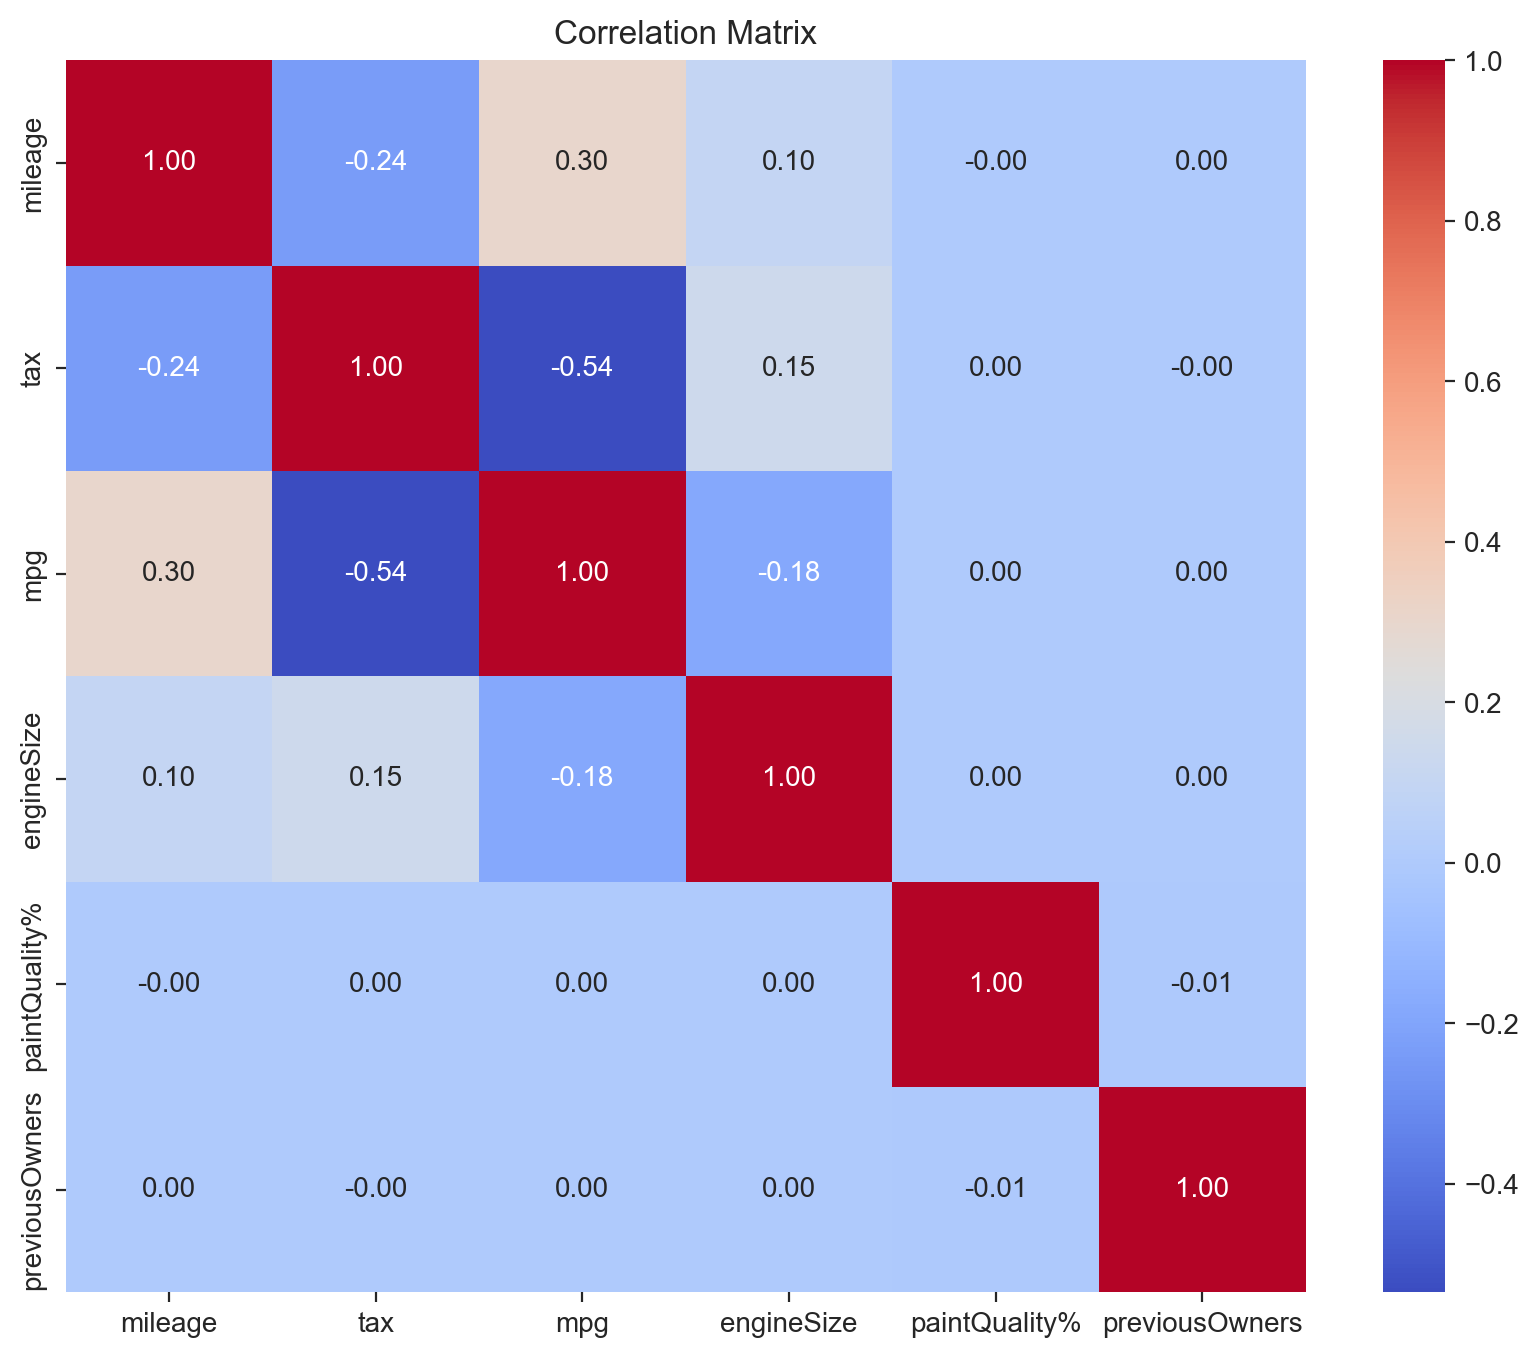

In [19]:
corr = X_train[metric_features].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

mpg is negatively correlated with tax however all other seems uncorrelated
mileage also positively correlated with mpg which makes sense

In [20]:
pd.crosstab(X_train['Brand'], X_train['model'], margins=True)
pd.crosstab(X_train['transmission'], X_train['fuelType'], margins=True)



fuelType,Diesel,Electric,Hybrid,Other,Petrol,All
transmission,,,,,,
Automatic,7798,4,1868,144,5072,14886
Manual,12896,0,21,18,27875,40810
Semi-Auto,9238,0,267,0,7034,16539
All,29932,4,2156,162,39981,72235


In [21]:
#Como corrigir os outros outliers e se relamente devem ser retirados?

Creating a feature to check how old the car is

In [22]:
X_train["CarAge"]=2025-X_train["year"]
